In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import tensorflow as tf

## create a graph
g = tf.Graph()
with g.as_default():
    x = tf.placeholder(dtype=tf.float32, shape=(None), name='x')
    w = tf.Variable(2.0, name='weight')
    b = tf.Variable(0.7, name='bias')
    z = w*x + b
    init = tf.global_variables_initializer()

## create a session and pass in graph g
with tf.Session(graph=g) as sess:
    ## initialize w and b:
    sess.run(init)
    ## evaluate z:
    for t in [1.0, 0.6, -1.8]:
        print('x=%4.1f --> z=%4.1f'%(t, sess.run(z, feed_dict={x:t})))

/Users/henryjing/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


x= 1.0 --> z= 2.7
x= 0.6 --> z= 1.9
x=-1.8 --> z=-2.9


In [3]:
with tf.Session(graph=g) as sess:
    sess.run(init)
    print(sess.run(z, feed_dict={x:[1., 2., 3.]}))

[ 2.70000005  4.69999981  6.69999981]


## Working with array structures

In [4]:
import tensorflow as tf
import numpy as np

g = tf.Graph()
with g.as_default():
    x = tf.placeholder(dtype=tf.float32, shape=(None, 2, 3), name='input_x')
    x2 = tf.reshape(x, shape=(-1,6), name='x2')
    ##calculate the sum of each column
    xsum = tf.reduce_sum(x2, axis=0, name='col_sum')
    ##calculate the mean of each column
    xmean = tf.reduce_mean(x2, axis=0, name='col_mean')
with tf.Session(graph=g) as sess:
    x_array = np.arange(18).reshape(3,2,3)
    print('input shape: ', x_array.shape)
    print('Reshaped:\n', sess.run(x2, feed_dict={x:x_array}))
    print('Column Sums:\n', sess.run(xsum, feed_dict={x:x_array}))
    print('Column Means:\n', sess.run(xmean, feed_dict={x:x_array}))
    

input shape:  (3, 2, 3)
Reshaped:
 [[  0.   1.   2.   3.   4.   5.]
 [  6.   7.   8.   9.  10.  11.]
 [ 12.  13.  14.  15.  16.  17.]]
Column Sums:
 [ 18.  21.  24.  27.  30.  33.]
Column Means:
 [  6.   7.   8.   9.  10.  11.]


## Simple model with the low-level TensorFlow API

In [11]:
import tensorflow as tf
import numpy as np

X_train = np.arange(10).reshape((10, 1))
y_train = np.array([1.0, 1.3, 3.1,
                     2.0, 5.0, 6.3,
                     6.6, 7.4, 8.0,
                     9.0])

In [7]:
class TfLinreg(object):
    def __init__(self, x_dim, learning_rate = 0.01, random_seed=42):
        self.x_dim = x_dim
        self.learning_rate = learning_rate
        self.g = tf.Graph()
        ## build the model
        with self.g.as_default():
            ## set graph-level random-seed
            tf.set_random_seed(random_seed)
            
            self.build()
            ## create initializer
            self.init_op = tf.global_variables_initializer()
            
    def build(self):
        ## define placeholders for inputs
        self.X = tf.placeholder(dtype = tf.float32, shape=(None, self.x_dim), name='x_input')
        self.y = tf.placeholder(dtype = tf.float32, shape=(None), name='y_input')
        print(self.X)
        print(self.y)
        ## define weight matrix and bias vector
        w = tf.Variable(tf.zeros(shape=(1)), name='weight')
        b = tf.Variable(tf.zeros(shape=(1)), name='bias')
        print(w)
        print(b)
        
        self.z_net = tf.squeeze(w*self.X + b, name='z_net')
        print(self.z_net)
        
        sqr_errors = tf.square(self.y - self.z_net, name='sqr_errors')
        print(sqr_errors)
        self.mean_cost = tf.reduce_mean(sqr_errors, name='mean_cost')
        
        optimizer = tf.train.GradientDescentOptimizer(learning_rate=self.learning_rate, name='GradientDescent')
        self.optimizer = optimizer.minimize(self.mean_cost)
        

In [8]:
lrmodel = TfLinreg(x_dim=X_train.shape[1], learning_rate=0.01)

Tensor("x_input:0", shape=(?, 1), dtype=float32)
Tensor("y_input:0", dtype=float32)
<tf.Variable 'weight:0' shape=(1,) dtype=float32_ref>
<tf.Variable 'bias:0' shape=(1,) dtype=float32_ref>
Tensor("z_net:0", dtype=float32)
Tensor("sqr_errors:0", dtype=float32)


In [22]:
def train_linreg(sess, model, X_train, y_train, num_epochs=10):
    ## initialize all variables: W and b
    sess.run(model.init_op)
    
    training_costs = []
    for i in range(num_epochs):
        _, cost = sess.run([model.optimizer, model.mean_cost], 
                           feed_dict = {model.X:X_train, model.y:y_train})
        training_costs.append(cost)
        
    return training_costs

In [19]:
sess = tf.Session(graph=lrmodel.g)
training_costs = train_linreg(sess, lrmodel, X_train, y_train)

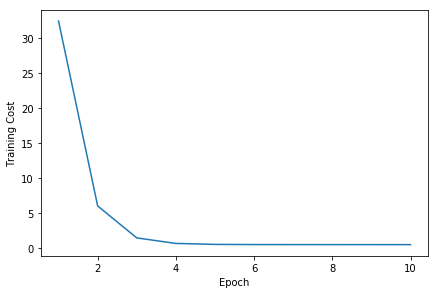

In [20]:
import matplotlib.pyplot as plt
plt.plot(range(1, len(training_costs) + 1), training_costs)
plt.tight_layout()
plt.xlabel('Epoch')
plt.ylabel('Training Cost')
plt.show()

In [24]:
def predict_linreg(sess, model, X_test):
    y_pred = sess.run(model.z_net, 
                      feed_dict={model.X:X_test})
    return y_pred

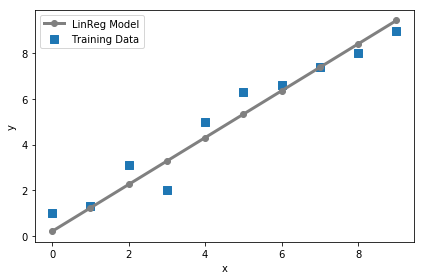

In [25]:
plt.scatter(X_train, y_train, 
            marker='s', s=50, 
            label='Training Data')
plt.plot(range(X_train.shape[0]), 
         predict_linreg(sess, lrmodel, X_train), 
         color='gray', marker='o',
         markersize=6, linewidth=3,
         label='LinReg Model')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.tight_layout()
plt.show()